In [1]:
import os
import sys
import torch
import time
import shutil
from torchvision.transforms import ToPILImage
from os.path import join

base_directory = "../"
sys.path.insert(0, base_directory)

output_base_dir = join(base_directory, "./output/sd2-notebook/")
output_directory = join(output_base_dir, "unet/")

try:
    shutil.rmtree(output_directory)
except Exception as e:
    print(e, "\n", "Creating the path...")
    os.makedirs(output_directory, exist_ok=True)
else:
    os.makedirs(output_directory, exist_ok=True)

from stable_diffusion.stable_diffusion import StableDiffusion
from stable_diffusion.utils.model import *
from stable_diffusion.utils.utils import *
from stable_diffusion.constants import ModelsPathTree


to_pil = lambda image: ToPILImage()(torch.clamp((image + 1.0) / 2.0, min=0.0, max=1.0))

In [2]:
device = get_device()

INFO: Using CUDA device: NVIDIA GeForce RTX 3080 Ti


In [3]:
pt = ModelsPathTree(base_directory=base_directory)

In [4]:
# initialize an empty stable diffusion class
stable_diffusion = StableDiffusion(device=device)
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 11086 MiB
Used: 1201 MiB


In [5]:
# initialize an empty latent diffusion model; it returns self.model
stable_diffusion.quick_initialize()
get_memory_status()

INFO: Using CUDA device 0: NVIDIA GeForce RTX 3080 Ti.
Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [6]:
# to use the unet we first need conditioning context. we can use the clip embedder to get it.
stable_diffusion.model.load_clip_embedder(**pt.embedder)
get_memory_status()

Total: 12287 MiB
Free: 10630 MiB
Used: 1657 MiB


In [7]:
# load the embedder submodels, tokenizer and transformer
stable_diffusion.model.clip_embedder.load_submodels(**pt.embedder_submodels)
get_memory_status()

Total: 12287 MiB
Free: 10124 MiB
Used: 2163 MiB


In [8]:
stable_diffusion.model.clip_embedder

CLIPTextEmbedder(
  (transformer): CLIPTextModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768,

In [9]:
# get the embedding for a prompt
prompt_embedding = stable_diffusion.model.clip_embedder(
    ["A woman with flowers in her hair in a courtyard, in the style of Frank Frazetta"]
)

In [10]:
get_memory_status()
prompt_embedding.shape

Total: 12287 MiB
Free: 9682 MiB
Used: 2605 MiB


torch.Size([1, 77, 768])

In [11]:
# we don't need the embedder anymore, so we can unload it
stable_diffusion.model.unload_clip_embedder()
get_memory_status()

Total: 12287 MiB
Free: 9682 MiB
Used: 2605 MiB


In [12]:
# let's save the prompt embedding
torch.save(prompt_embedding, join(output_base_dir, "prompt_embedding.pt"))

In [13]:
# the latent diffusion class has a method to load the unet, since it is a submodel of it. it returns the unet model, wrapped in a DiffusionWrapper class.
# it is accessible as self.model.model or through the alias self.model.unet
stable_diffusion.model.load_unet(**pt.unet)
get_memory_status()
stable_diffusion.model.unet

Total: 12287 MiB
Free: 6372 MiB
Used: 5915 MiB


In [14]:
# load an encoded image and get its shape
encoded_img = torch.load(join(output_base_dir, "encoded_img_tensor.pt")).to(device)
encoded_img.shape

torch.Size([1, 4, 64, 64])

In [15]:
# sample a latent representation of same shape as the encoded image
sample = torch.randn_like(encoded_img)
get_memory_status()

Total: 12287 MiB
Free: 6372 MiB
Used: 5915 MiB


In [16]:
# define a timestep for this sample
time_step = torch.tensor([0.0]).to(device)
time_step.shape

torch.Size([1])

In [17]:
# predict noise with the unet
unet_output = stable_diffusion.model.unet(sample, time_step, prompt_embedding)

In [18]:
get_memory_status()
unet_output.shape

Total: 12287 MiB
Free: 0 MiB
Used: 12287 MiB


torch.Size([1, 4, 64, 64])

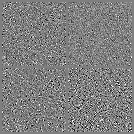

In [19]:
grid = torchvision.utils.make_grid(
    unet_output.permute(1, 0, 2, 3),
    nrow=2,
    normalize=False,
    range=(-1, 1),
    scale_each=True,
    pad_value=0,
)
dim_grid_image = to_pil(grid)
dim_grid_image.save(join(output_directory, f"unet_output.png"))
dim_grid_image

In [20]:
stable_diffusion.model.unload_submodels()
torch.cuda.empty_cache()
get_memory_status()

Total: 12287 MiB
Free: 0 MiB
Used: 12287 MiB
